Scope: Calculations to assist with designing the injector bench feed system

Test Goal: Characterize an injector orifice and flow regime (cavitating, non cavitating)

Method: Use Cold Flow Test data to iteratively solve Cd for a given geometry by matching m_dot (for liquid phase)

| Measurement:                      | Sensor:                                   | Justification / Purpose:                             |
|-----------------------------------|-------------------------------------------|------------------------------------------------------|
| Mass flow rate through orifice    | Load Cell on run tank                     | Experimental mass flow from load vs time for test, Fitting model m_dot |
| Upstream tank pressure            | Pressure transducer on run tank           | Ensuring model tank pressure matches recorded run tank pressure    |
| Injector orifice inlet pressure | Pressure transducer before injector orifice inlet | Discovered through estimating feed line size that the pressure drop between the tank exit and the injector inlet was great enough that it required another transducer |
| Downstream chamber pressure          | Pressure transducer in downstream chamber    | Fitting model m_dot by matching model P to tank P    |
| Downstream chamber temperature       | Thermocouple on tank                      | Check P_sat(T) for nitrous flow regime                   |
| Upstream chamber temperature       | Thermocouple on tank                      | Check P_sat(T) for nitrous flow regime                   |

same test as [6] - use this as a reference

Problems to solve to build the test stand:
1) Estimate Line Losses
2) Max Cv
3) Spec Valves - Find torque on valve and consider controls solutions
4) 

Guiding Tenent:
- We are behind schedule (3 years) and need this test as soon as possible. The design choice should be whatever makes the test happen the quickest while ensuring a high enough quality so the test is worthwhile


1) Estimate Line Losses

Goals:
- Ensure nitrous is a liquid upstream of injector --> Check P_feed > P_sat
- Ensure pressure drop is low 

Approach: use rocketprops library (Darcy Weishbach eqn)

The flow condition where we will see the maximum pressure drop determined by Darcy Weishbach eqn:

deltaP = friction_factor * (8 * fric_factor /pi^2) * (L/D^5) * (m_dot/rho)

- L/D fixed by test geometry
- m_dot and rho are unknown. We will need to approx by fluid model.
--> if the pressure drop is low compared to the injector, we can assume that the line resistance is negligible and the mass flow will be restricted/set by the injector. 
- We just care about a small pressure drop, so if we use a conservative estimate and find a low pressure drop, we can proceed with the geometry
- Highest m_dot estimate if we use SPI injector model
--> Highest m_dot_spi at highest pressure across orifice (if pressure drops past P_sat, this will be a severe overprediction)
--> flow will probably behave close to this way as long as P_feed > P_sat (no flashing to vapor)

Not sure relationship between m_dot and rho so take initial point and final point of liquid phase

From guiding tenent, first pass try to size with 1/4-18 NPT (existing/found hardware) and assume we use the same plumbing as [6]

from [6] tank --> 4 way junction --> 4X 90 degree bend

from fluids textbook: (used threaded values)
4 way junction K --> approx as Tee branch flow = 2.0
90 degree bend K = 0.9
K_total = 5.6

In [30]:
import numpy as np
import CoolProp.CoolProp as CP
from rocketprops.rocket_prop import get_prop
from rocketprops.line_supt import calc_line_vel_dp

# --- Unit conversions ---
PA_TO_PSI = 1 / 6894.75729
M_TO_IN = 39.3701
KG_S_TO_LBM_S = 2.20462
K_TO_R = 1.8

# --- Pipe and fluid setup ---
pipe_ID = 0.0254*(1/4)       # pipe inner diameter [m] 
print(f"Pipe Diam: {pipe_ID} (m),  = 1/4 in")
#pipe_ID = 0.0254*(3/8)       # pipe inner diameter [m] 
pipe_L = 1            # pipe length [m]
print(f"Pipe Length: {pipe_L} (m),  = {pipe_L/0.0254} in")
pipe_roughness = 1e-6   # pipe roughness [m]
pipe_K_total = 5.6        # ignore fittings

T_liquid = 263.15  # liquid temperature [K]

P_upstream = 3e6
P_downstream = 2.5e6

rho_liq = CP.PropsSI('D', 'T', T_liquid, 'P', P_upstream, 'N2O')

# --- SPI injector mass flow model (simplified) ---
def m_dot_spi(P_upstream, P_downstream, rho_liq):
    """Compute mass flow rate through SPI injector (kg/s)."""
    D_orifice = 3e-3 #m
    A_orifice = 0.25*np.pi*(D_orifice)**2  # m^2
    print("Injector D_orifice: ", D_orifice)
    C_d = 0.6
    delta_P = P_upstream - P_downstream
    return C_d * A_orifice * (2 * rho_liq * delta_P)**0.5

# --- Compute SPI mass flow ---
m_dot = m_dot_spi(P_upstream, P_downstream, rho_liq)

# --- Compute line ΔP using rocketprops ---
pObj = get_prop('N2O')
vel, deltaP_line = calc_line_vel_dp(
    pObj, 
    T_liquid * K_TO_R, 
    P_upstream * PA_TO_PSI,
    m_dot * KG_S_TO_LBM_S,
    pipe_ID * M_TO_IN, 
    pipe_roughness* M_TO_IN, 
    pipe_K_total, 
    pipe_L* M_TO_IN
    )

deltaP_line/=PA_TO_PSI

print(f"Upstream pressure: {P_upstream:.2f} Pa, Liquid Density: {rho_liq:.2f}")
print(f"SPI mass flow: {m_dot:.4f} kg/s")
print(f"Pipe pressure drop: {deltaP_line:.2f} Pa (does not include inj pressure drop)")

pcnt_dp = deltaP_line/(P_upstream - P_downstream)*100
print(f"Percent pressure drop (line/(up-down)): {pcnt_dp:.2f} %")

V_line = pipe_L * 0.25*np.pi*(pipe_ID)**2
print(f"Volume in feed lines: {V_line} m^3 %, {V_line*1000} L")


# Determine the phase of nitrous oxide at the downstream conditions
phase = CP.PhaseSI("P", P_downstream, "T", T_liquid, "N2O")

# Check if it’s liquid or not
if phase in ["liquid", "compressed_liquid"]:
    print("P_downstream > P_sat. Liquid at exit, calc valid")
else:
    print(f"INVALID CALC! {phase.upper()} at exit, likely cavitation")



Pipe Diam: 0.00635 (m),  = 1/4 in
Pipe Length: 1 (m),  = 39.37007874015748 in
Injector D_orifice:  0.003
Upstream pressure: 3000000.00 Pa, Liquid Density: 958.42
SPI mass flow: 0.1313 kg/s
Pipe pressure drop: 72971.32 Pa (does not include inj pressure drop)
Percent pressure drop (line/(up-down)): 14.59 %
Volume in feed lines: 3.1669217443593606e-05 m^3 %, 0.031669217443593606 L
P_downstream > P_sat. Liquid at exit, calc valid


DeltaP Sensitivity from playing around:
- relatively insensitive to line length (at the length scales we are working at)
- somewhat sensitive to K
- mostly sensitive to m_dot_spi (also Cd)
- very insensitive to roughness

Saw a pressure drop % below ____%, so can proceed with ______ lines!

2) Find Max CV for valves:

this is very similar to the last task, except using the previous baseline find the maximum possible Cv to spec the valve

In [19]:
import numpy as np
import CoolProp.CoolProp as CP
from rocketprops.rocket_prop import get_prop
from rocketprops.valve_supt import cv_valve_dp

# --- Unit conversions ---
PA_TO_PSI = 1 / 6894.75729
M_TO_IN = 39.3701
KG_S_TO_LBM_S = 2.20462
K_TO_R = 1.8

# --- FROM DATASHEET --- 
cv_water = 3 

# --- Thermo / operating conditions ---
T_liquid = 283.15            # liquid temperature [K]
P_upstream = 5e6             # upstream pressure [Pa]
P_downstream = 4e6           # downstream pressure [Pa]

# --- Liquid density from CoolProp at upstream pressure ---
rho_liq = CP.PropsSI('D', 'T', T_liquid, 'P', P_upstream, 'N2O')

cv = cv_water*np.sqrt(998/rho_liq) #convert cv from water (datasheet) to nitrous

# --- SPI injector mass flow model (simplified) ---
def m_dot_spi(P_upstream, P_downstream, rho_liq):
    """Compute mass flow rate through SPI injector (kg/s)."""
    A_orifice = 0.25 * np.pi * (3e-3)**2  # m^2 (example orifice)
    C_d = 1.0
    delta_P = P_upstream - P_downstream
    if delta_P <= 0:
        return 0.0
    return C_d * A_orifice * np.sqrt(2.0 * rho_liq * delta_P)

# --- Compute SPI mass flow ---
m_dot = m_dot_spi(P_upstream, P_downstream, rho_liq)

# --- Setup rocketprops property object and convert temperature to Rankine if needed ---
pObj = get_prop('N2O')

# Call the cv -> deltaP helper. The function signature:
#   valve_deltaP = cv_valve_dp(pObj, cv, m_dot, T_op_R, p_valve_inlet)
valve_deltaP = cv_valve_dp(
    pObj, 
    cv, 
    m_dot * KG_S_TO_LBM_S,
    T_liquid * K_TO_R, 
    P_upstream * PA_TO_PSI
    )

valve_deltaP/=PA_TO_PSI

# --- Output results ---
print(f"Upstream pressure: {P_upstream:.2f} Pa")
print(f"Downstream pressure: {P_downstream:.2f} Pa")
print(f"Liquid density (CoolProp): {rho_liq:.3f} kg/m^3")
print(f"SPI mass flow (approx): {m_dot:.6f} kg/s")

print(f"Valve Cv: {cv}")
print(f"Valve ΔP (from cv_valve_dp): {valve_deltaP:.2f} Pa")

# percent of the upstream->downstream pressure difference that the valve ΔP represents
pcnt_dp_valve = valve_deltaP / (P_upstream - P_downstream) * 100.0
print(f"Percent pressure drop (valve / (up - down)): {pcnt_dp_valve:.3f} %")

# check vapor pressure

P_sat = CP.PropsSI('P', 'T', T_liquid, 'Q', 0, 'N2O')
print(f"P_sat assuming isothermal (overprediction): {P_sat:.2f} < {P_upstream-valve_deltaP:.2f} should be true")



Upstream pressure: 5000000.00 Pa
Downstream pressure: 4000000.00 Pa
Liquid density (CoolProp): 863.348 kg/m^3
SPI mass flow (approx): 0.293725 kg/s
Valve Cv: 3.2254748846450747
Valve ΔP (from cv_valve_dp): 16664.72 Pa
Percent pressure drop (valve / (up - down)): 1.666 %
P_sat assuming isothermal (overprediction): 4001201.99 < 4983335.28 should be true


2) Results: for our expected operating conditions, the valve losses are much smaller than line losses

3) Spec Valves:

From the previous steps we know:
- pipe id
- expected deltaP
- Possible maximum Cv



In [20]:
import math

def valve_torque(
    D_ball,           # Ball diameter [m]
    w_seat,           # Seat width [m]
    deltaP,           # Pressure drop across valve [Pa]
    mu_seat,          # Seat friction coefficient
    T_pack=0.0,       # Packing torque [Nm]
    f_breakout=2.0,   # Breakout factor (typical 1.5–3.0)
    f_safety=1.3      # Safety factor (typical 1.2–1.5)
):
    """
    Calculate running torque, breakout torque, and actuator torque for a ball valve.
    
    Returns: T_run, T_breakout, T_actuator [Nm]
    """
    # --- Seat friction torque ---
    A_seat = math.pi * D_ball * w_seat               # Contact area [m^2]
    F_seat = deltaP * A_seat                          # Seat force [N]
    r_lever = D_ball / 2                              # Lever arm [m]
    T_seat = F_seat * mu_seat * r_lever              # Torque from seat friction [Nm]

    # --- Flow-induced torque (optional, often small) ---
    A_proj = math.pi * D_ball**2 / 4
    e_lever = 0.2 * D_ball
    T_flow = deltaP * A_proj * e_lever

    # --- Running torque ---
    T_run = T_seat + T_flow + T_pack

    # --- Breakout torque ---
    T_breakout = T_run * f_breakout

    # --- Actuator torque with safety factor ---
    T_actuator = T_breakout * f_safety

    return T_run, T_breakout, T_actuator

# --- Example usage ---
D_ball = 0.0254*(0.25)      # 1 inch ball [m]
w_seat = 0.003       # 3 mm seat width
deltaP = 5e6 - 4e6   # 1 MPa pressure drop
mu_seat = 0.1        # soft PTFE seat
T_pack = 0.0         # assume unknown

T_run, T_breakout, T_actuator = valve_torque(D_ball, w_seat, deltaP, mu_seat, T_pack)
print(f"T_run: {T_run:.2f} Nm")
print(f"T_breakout: {T_breakout:.2f} Nm")
print(f"T_actuator (with safety factor): {T_actuator:.2f} Nm")


T_run: 0.06 Nm
T_breakout: 0.12 Nm
T_actuator (with safety factor): 0.15 Nm


Next want to estimate the fill time of downstream chamber. If we could use an accurate method, we wouldn't really need to test (inj flowrate models do not let us solve enthalpy change)


Real quick, plot pressure vs mass in chamber, estimate an average mass flow to get a rough idea of fill time.

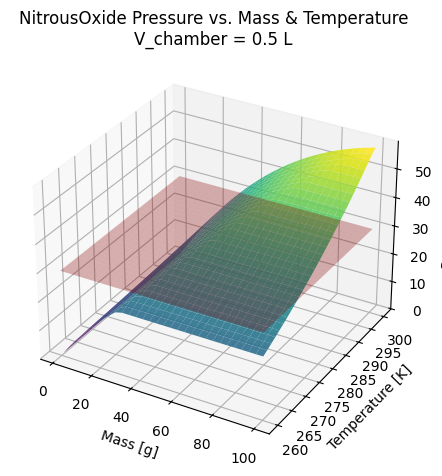

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from mpl_toolkits.mplot3d import Axes3D

# --- Parameters ---
fluid = 'NitrousOxide'   # Or 'N2O' if you have aliases set up
V_chamber = 0.000510994        # m^3, example downstream chamber volume
T_range = np.linspace(260, 300, 30)  # K, range of temperatures
m_range = np.linspace(0.001, 0.1, 30)  # kg, mass of fluid in chamber

# --- Arrays for plotting ---
T_grid, m_grid = np.meshgrid(T_range, m_range)
P_grid = np.zeros_like(T_grid)

# --- Compute pressure for each T, m ---
for i in range(T_grid.shape[0]):
    for j in range(T_grid.shape[1]):
        T = T_grid[i, j]
        m = m_grid[i, j]
        rho = m / V_chamber
        try:
            P = PropsSI('P', 'D', rho, 'T', T, fluid)
        except:
            P = np.nan
        P_grid[i, j] = P / 1e5  # convert to bar

# --- 3D Plot ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(m_grid*1000, T_grid, P_grid, cmap='viridis', alpha=0.9)

# --- Add a horizontal plane at 30 bar ---
P_target = 30  # bar
ax.plot_surface(
    m_grid*1000,  # x (mass)
    T_grid,       # y (temperature)
    np.full_like(P_grid, P_target),  # z constant at 30 bar
    color='red',
    alpha=0.3,
    label='30 bar plane'
)

# --- Labels ---
ax.set_xlabel('Mass [g]')
ax.set_ylabel('Temperature [K]')
ax.set_zlabel('Pressure [bar]')
ax.set_title(f'{fluid} Pressure vs. Mass & Temperature\nV_chamber = {V_chamber*1e3:.1f} L')

plt.tight_layout()
plt.show()
